1. cell type 
2. coarse cell type

check elbo between wrong and correct ones

In [2]:
cd ..

/home/mffang/workspace/Poisson-regression


In [3]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" #

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.poisson_mixture import PoissonMixture
from RADOM.gamma_poisson_mixture import GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

2023.04.12.10


In [4]:
from scipy.stats import spearmanr
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

# Load data

In [5]:
adata = sc.read('data/hgForebrainGlut.loom')
adata.var_names_make_unique
adata

AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [6]:
clusters = adata.obs["Clusters"]
Clusters = set(clusters)
print(Clusters)
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
cell_colors = colors20[np.mod(clusters, 20)]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", colors20[:7], N=7)

{0, 1, 2, 3, 4, 5, 6}


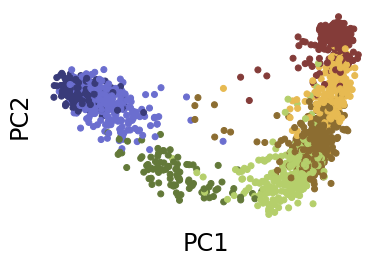

In [7]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+adata.X/total_UMI[:,None]*np.mean(total_UMI)))
x *= -1

fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [8]:
known_marker_genes=["SOX2","SLC17A7","EOMES"]
novel_marker_genes=["CLU","FBXO32","UNC5D","SEZ6","RBFOX1"]
their_genes=["DCX","GRIA3","STMN2", "FAM64A","ELAVL4","RNASEH2B"]
marker_genes = known_marker_genes + novel_marker_genes + their_genes

# Select genes

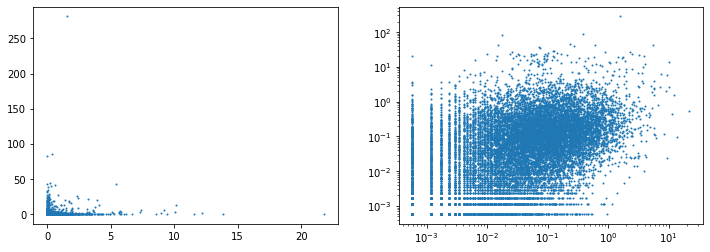

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [10]:
idx = (adata.layers["unspliced"].toarray().mean(0) > 0) 
U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))


idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = ((adata.layers["spliced"].toarray()+adata.layers["unspliced"].toarray()).mean(0) > 0) 
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X = U + S
X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.2118266912384779
s estimated by normalized covariance of total S counts = 0.20732547082006236
s estimated by normalized covariance of total counts = 0.2055849306469533
s estimated by total counts = 0.1051200890678582


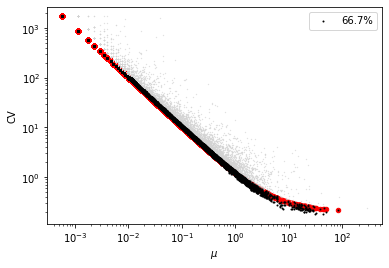

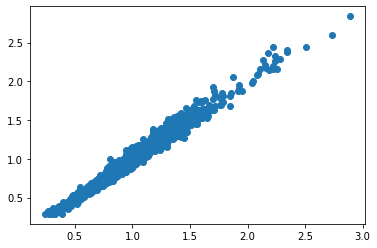

In [11]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)
a=1
s=s1
Pgene_mask = (X_bar > 0) & (X_var/(a*X_bar + s*X_bar**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.scatter(rd,adata.X.toarray().mean(1)/adata.X.toarray().mean())

s estimated by normalized covariance of Poission genes = 0.17318785776918832


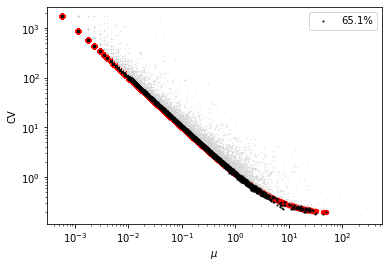

In [12]:
X = (S + U)[:,Pgene_mask]
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of Poission genes =", str(s))

Pgene_mask = (X_bar > 0) & (X_var/(a*X_bar + s*X_bar**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

(1720, 327, 2)

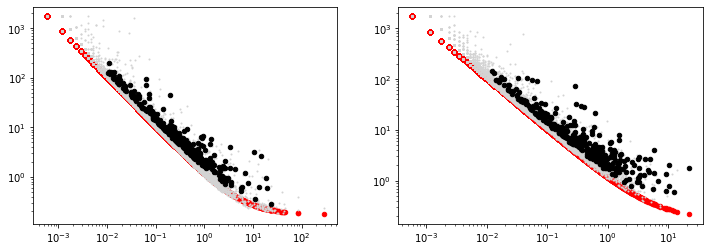

In [13]:
var_threshold = 1.3
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.01) & (S_mean > 0.01) \
    & (np.abs(np.log10(S_mean/U_mean)) < 2) \
    & (U_var/(a*U_mean + s*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + s*S_mean**2) > var_threshold)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + s, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + s, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

In [14]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['EOMES', 'CLU', 'FBXO32', 'RBFOX1', 'DCX', 'GRIA3', 'STMN2', 'FAM64A',
       'ELAVL4'],
      dtype='object', name='Gene')


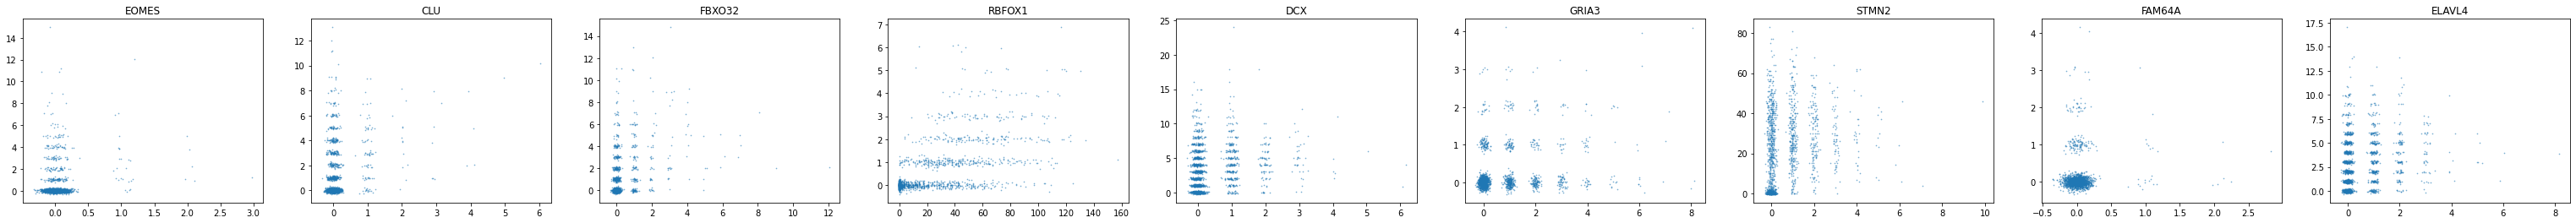

In [15]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

# Mixtures fitting

In [16]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

In [17]:
GPMs = []
for nc in range(3,9):
    GPM = GammaPoissonMixture(n_components=nc,verbose=0)
    Q, elbo = GPM.fit(X_mix,warm_start=False,epoch=5,n_init=3)
    GPMs.append(GPM)
    print(nc,GPM.compute_AIC(X_mix))

3 -545.8545348637676
4 -531.2103319177315
5 -527.1022178308377
6 -521.3573100301244
7 -511.9436715870195
8 -510.0251265562413


In [18]:
for GPM in GPMs:
    print(GPM.compute_BIC(X_mix))

-548.9709030363872
-535.3660175897098
-532.2972210021745
-527.5916307008199
-519.2173097570736
-518.338082225654


In [19]:
GPM = GammaPoissonMixture(n_components=4,verbose=0)
Q, elbo = GPM.fit(X_mix,warm_start=False,epoch=10,n_init=5)

In [48]:
GPM.weights, 1/GPM.alpha

(array([0.30589368, 0.2219747 , 0.15760187, 0.31452975]),
 array([0.10526137, 0.08911256, 0.14755081, 0.16330049]))

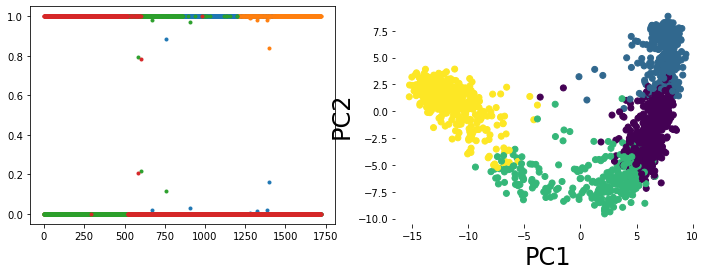

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=np.argmax(Q,axis=1));
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

Text(0.5, 1.0, 'intercept test p value')

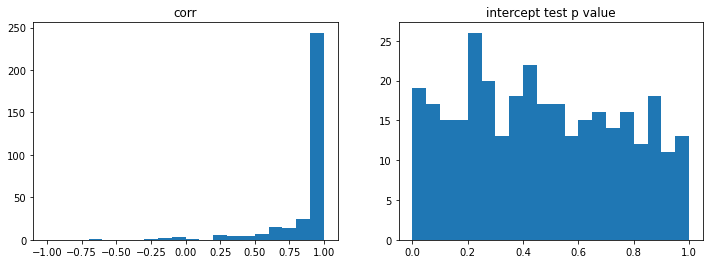

In [21]:
slope, intercept, corr, pval = linear_regression(GPM.theta)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(corr,bins=np.linspace(-1,1,21))
ax[0].set_title('corr')
ax[1].hist(pval,bins=np.linspace(0,1,21))
ax[1].set_title('intercept test p value')

# Trajectory fitting

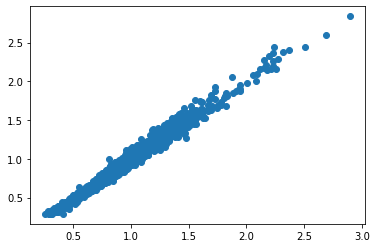

In [22]:
elbos = {}
params={'r':rd,"lambda_tau":0,"lambda_a":0}
plt.scatter(rd,adata.X.toarray().mean(1)/adata.X.toarray().mean())

## Fine cluster

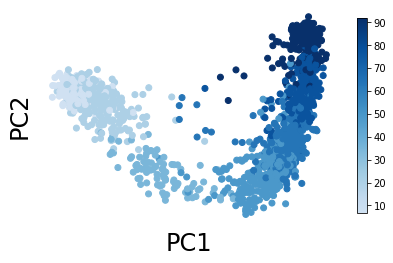

In [23]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=Q0[:,0]@np.arange(m).reshape([-1,1]),cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [24]:
topo = np.array([[0,1,2]])
tau = (0,12,24)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,Q=Q0,fit_tau=True,params=params,beta=10,parallel=True,n_threads=10,epoch=10)
print(traj.elbos[-1])

fitting with warm start


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]

-58.49423990425917


[ 0.         12.09058887 24.        ]


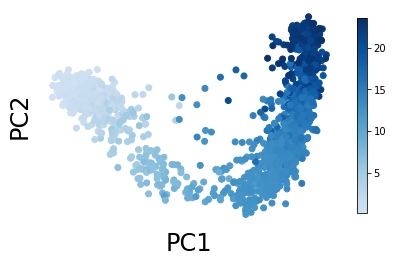

In [25]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

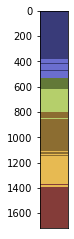

In [26]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

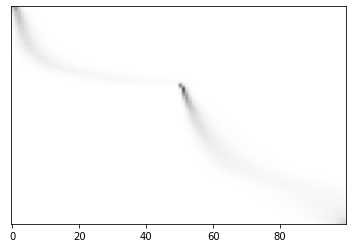

In [27]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

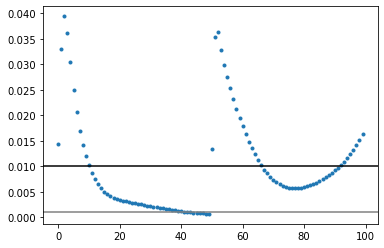

In [28]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

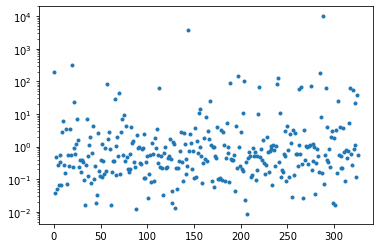

In [29]:
plt.plot(traj.theta[:,[-2]],'.')
plt.yscale('log')

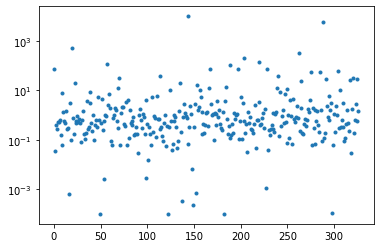

In [30]:
plt.plot(traj.theta[:,[-1]],'.')
plt.yscale('log')

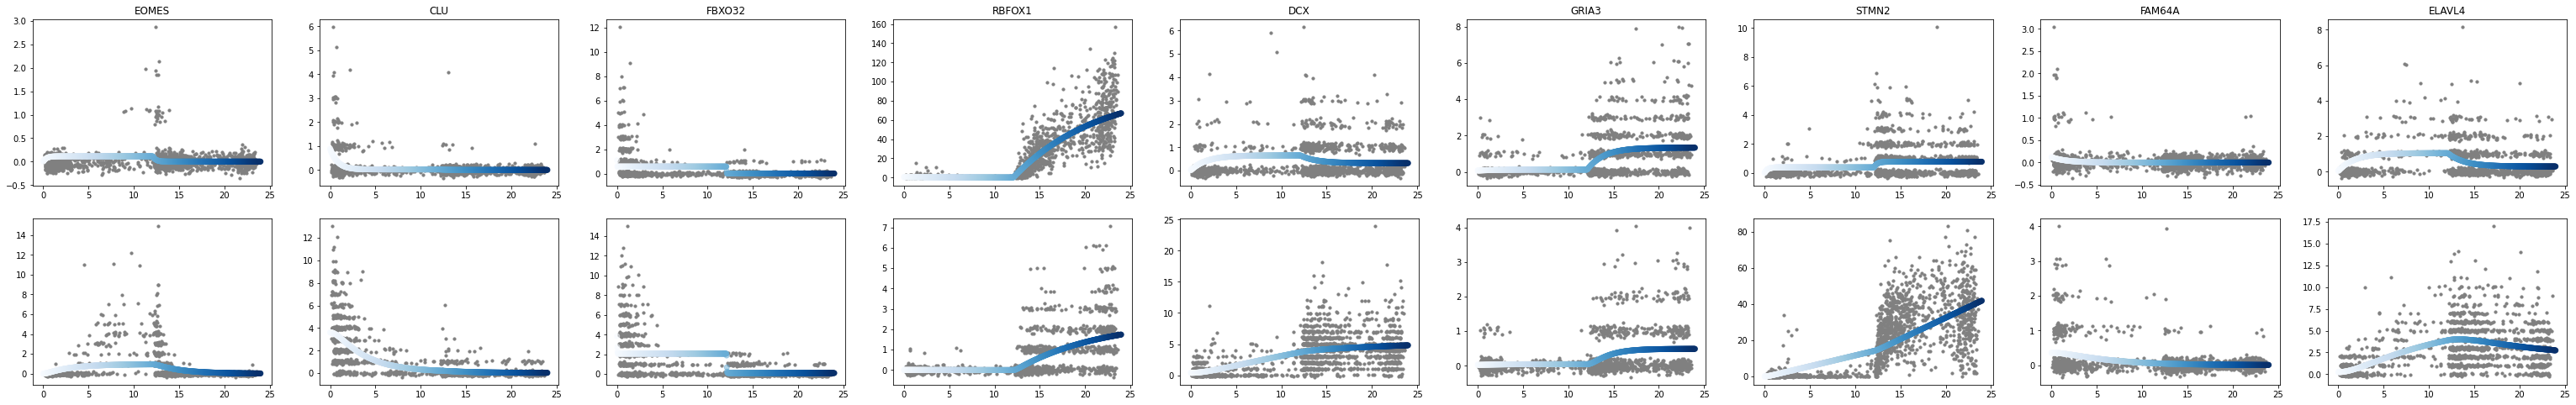

In [31]:
plot_y(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

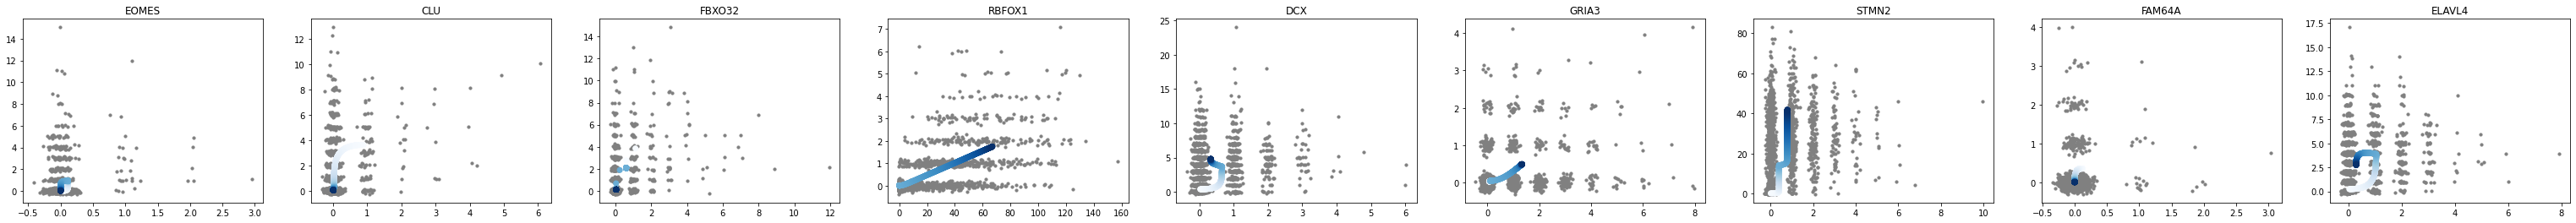

In [32]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

50


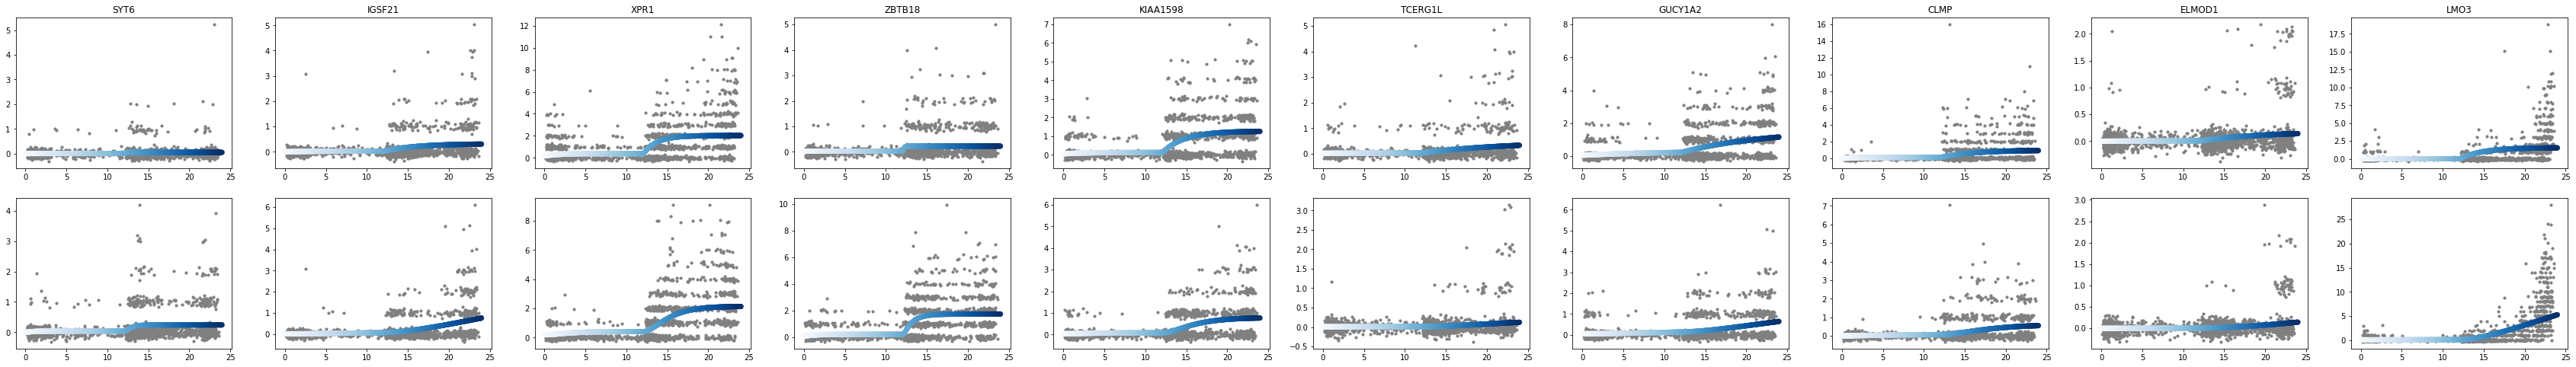

In [33]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

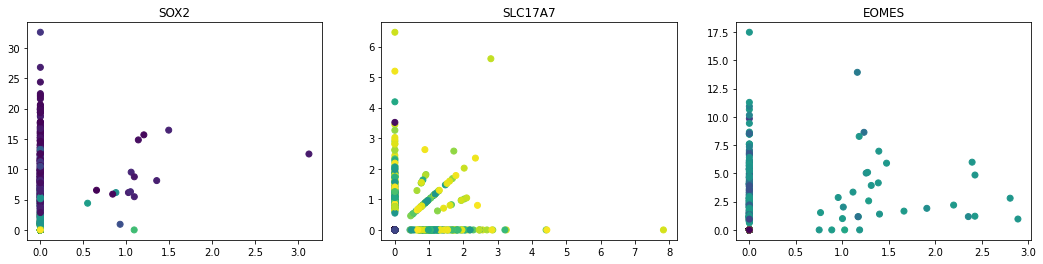

In [34]:
fig,ax = plt.subplots(1,len(known_marker_genes),figsize=(6*len(known_marker_genes),4))
for i,gene in enumerate(known_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

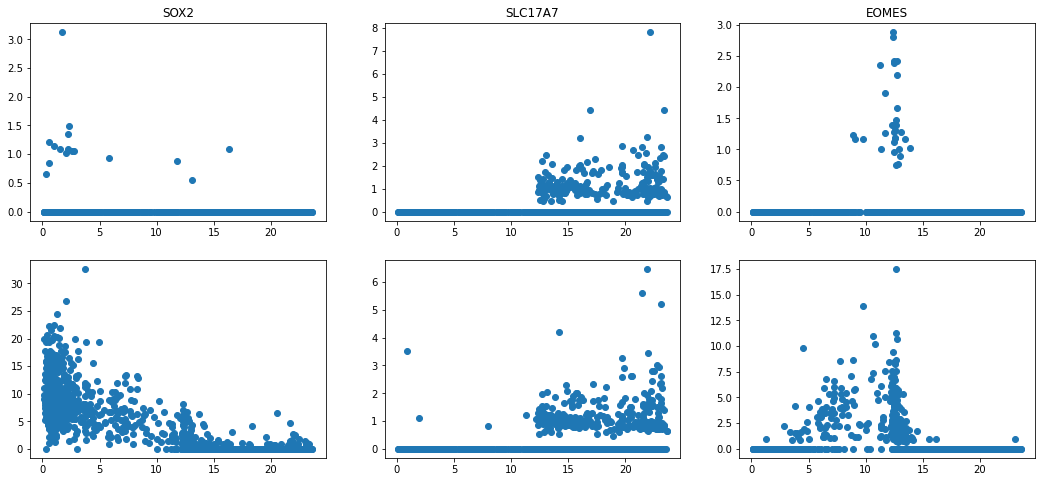

In [35]:
fig,ax = plt.subplots(2,len(known_marker_genes),figsize=(6*len(known_marker_genes),8))
for i,gene in enumerate(known_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

[Text(0, 0, 'α0'), Text(1, 0, 'α1'), Text(2, 0, 'α2')]

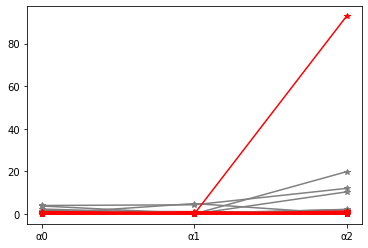

In [36]:
p=30
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

In [37]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

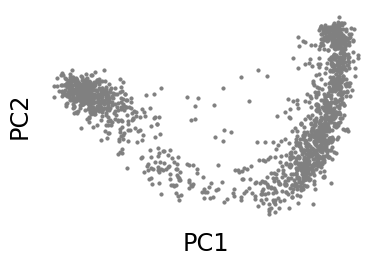

In [38]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [39]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=4, seed=seed)
    trajs.append(traj)

100%|██████████| 100/100 [27:29<00:00, 16.49s/it]


Text(0.5, 1.0, 'Random initialiazation')

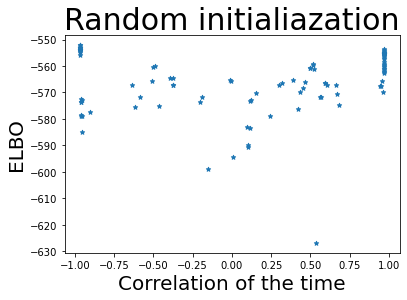

In [40]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [41]:
traj = trajs[np.argmax(elbos)]
np.max(elbos)

-552.1648734187934

[ 0. 24. 48.]


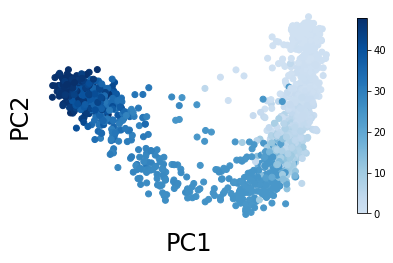

In [42]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

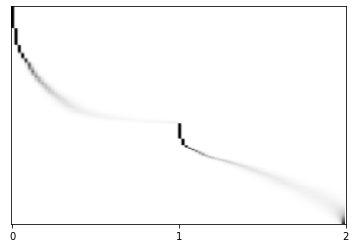

In [43]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

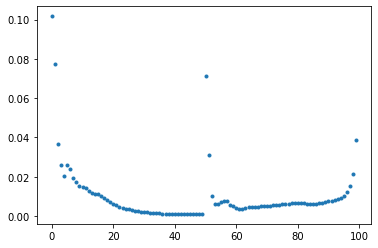

In [44]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')

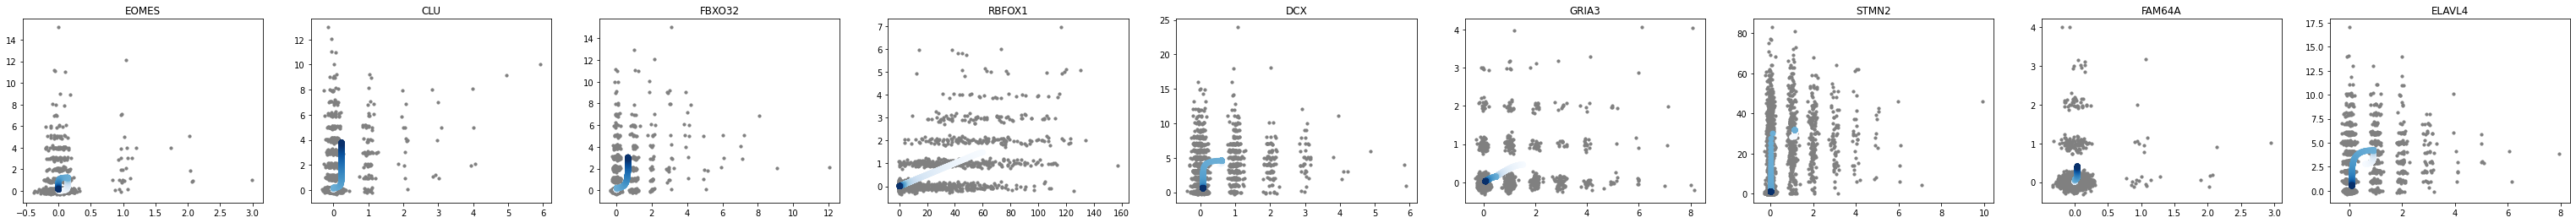

In [45]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

61


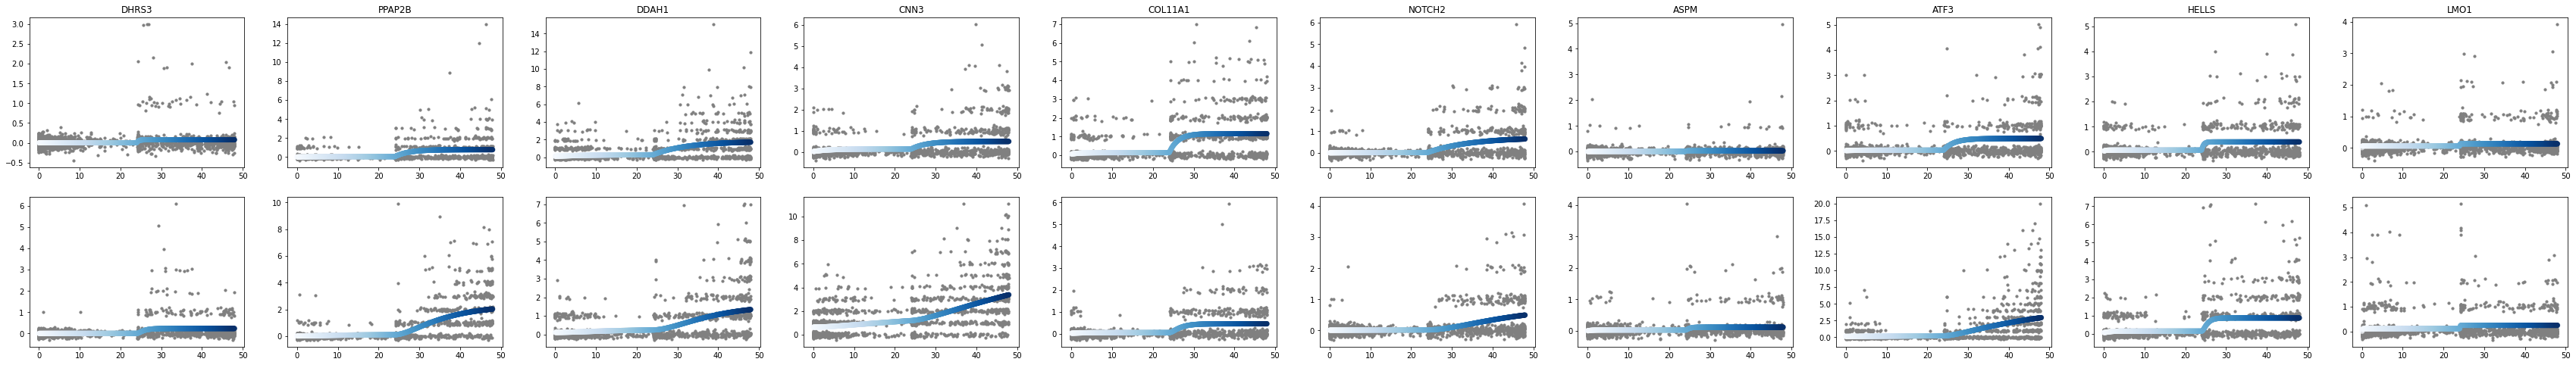

In [46]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

### two_species_ss_tau

In [49]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(20)):
    traj = Trajectory(topo, tau,  model="two_species_ss_tau", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 20/20 [09:51<00:00, 29.59s/it]


Text(0.5, 1.0, 'Random initialiazation')

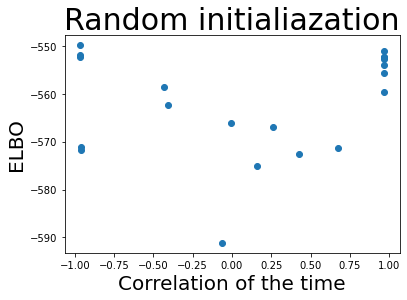

In [50]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [51]:
traj = trajs[np.argmax(elbos)]

(array([ 82.,   3.,  12.,   5.,  12.,  10.,  11.,  28.,   8., 156.]),
 array([23.5, 23.6, 23.7, 23.8, 23.9, 24. , 24.1, 24.2, 24.3, 24.4, 24.5]),
 <BarContainer object of 10 artists>)

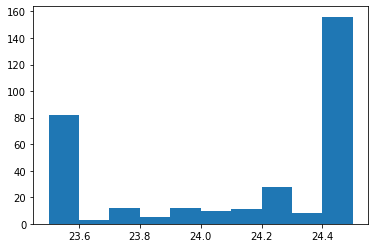

In [52]:
plt.hist(traj.theta[:,-3])

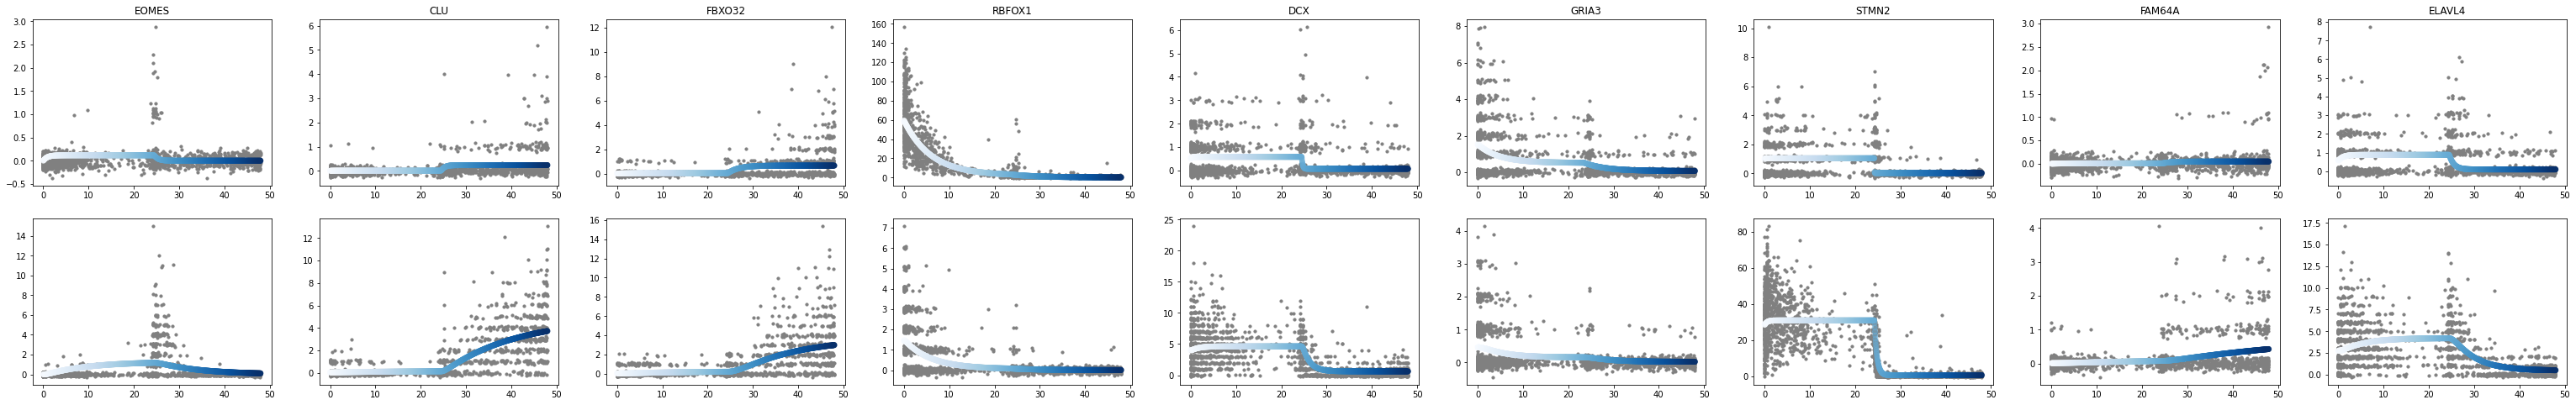

In [53]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

### two_species

In [54]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(20)):
    traj = Trajectory(topo, tau,  model="two_species", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, fit_tau=True, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=4, seed=seed)
    trajs.append(traj)

100%|██████████| 20/20 [07:18<00:00, 21.92s/it]


Text(0.5, 1.0, 'Random initialiazation')

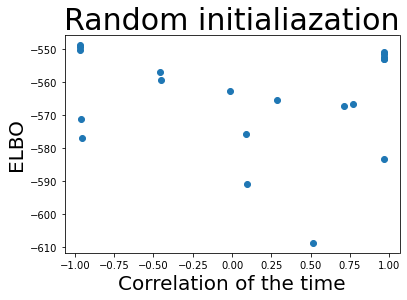

In [55]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [56]:
traj = trajs[np.argmax(elbos)]
traj.elbos[0][-1]

-548.9482323696172

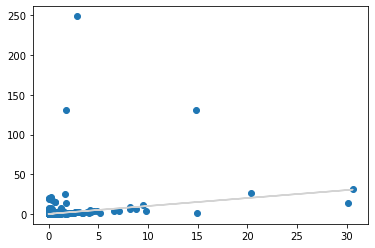

In [57]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

In [58]:
traj = trajs[np.argmax(corrs)]
traj.elbos[0][-1]

-551.0625493214612

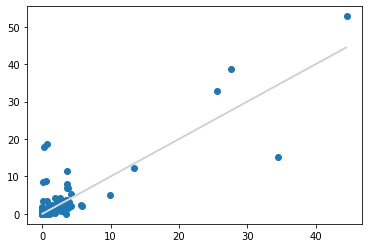

In [59]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

# Synthetic data

In [60]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=4,epoch=10)

fitting with warm start


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


In [61]:
print(traj.elbos[-1])

-561.4087930023201


[ 0.         24.20859939 48.        ]


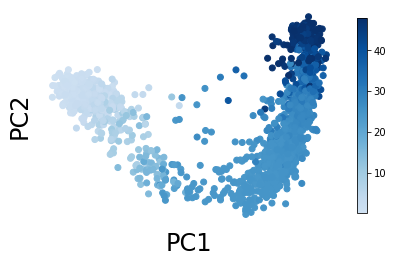

In [62]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

<AxesSubplot:>

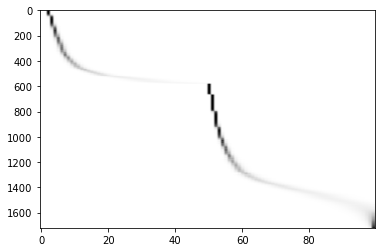

In [63]:
plot_t(traj,order_cells=True)

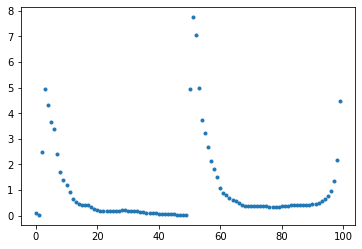

In [64]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

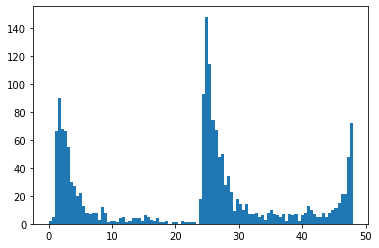

In [65]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

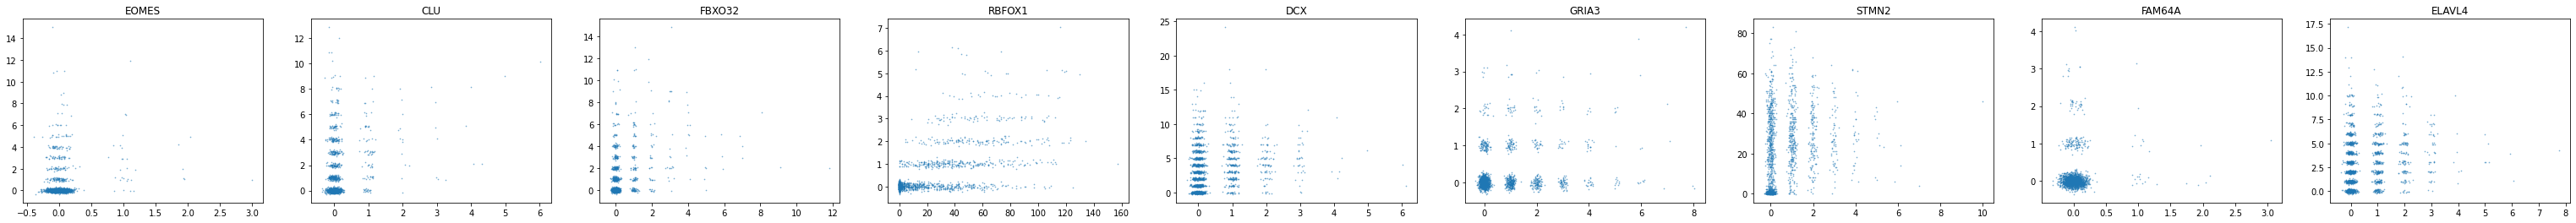

In [66]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [67]:
syn_tau = traj.tau.copy()
syn_topo = traj.topo.copy()
trajs = []
for seed in tqdm(range(20)):
    syn_traj = Trajectory(syn_topo, syn_tau,  model="two_species_ss", restrictions={}, verbose=0)
    syn_traj = syn_traj.fit(syn_X, warm_start=False, fit_tau=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=4, seed=seed)
    trajs.append(syn_traj)

100%|██████████| 20/20 [05:43<00:00, 17.19s/it]


Text(0.5, 1.0, 'Random initialiazation')

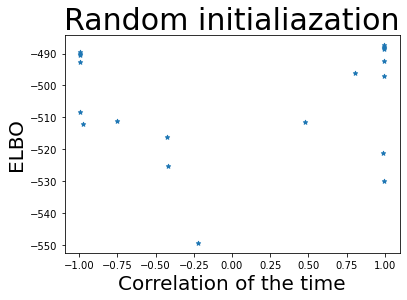

In [68]:
corrs = []
elbos = []
for syn_traj in trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [69]:
traj = trajs[np.argmax(elbos)]
traj.elbos[0][-1]

-487.3777832678636

[ 0.         24.20859939 48.        ]


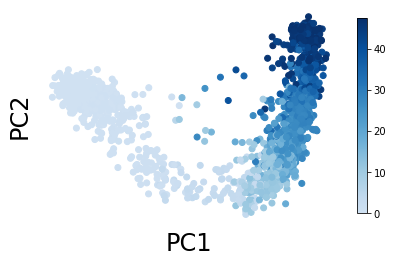

In [70]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right